# Multivariate LSTM

A multivariate LSTM is used to predict the price of the stock in this section. In general stocks are highly affected by external factors and therefore this complexity is ignored when a regular LSTM model, that only takes previously stock-price, into account.
Eventhough multivariate doesn't fully grasps the compleksity of this, it does a better job.

# Step1 loading and merging the timeseries data

https://www.relataly.com/stock-market-prediction-using-multivariate-time-series-in-python/1815/#h-implementing-a-multivariate-time-series-prediction-model-in-python 



In [2]:
#Import stuff
import pandas as pd
import numpy as np

In [143]:
#import input data
news = pd.read_csv(r"I:\python_file\save\M4 (1)\Sentiment Analysis\News_combined.csv", index_col=0)
stock = pd.read_csv(r"I:\python_file\save\M4 (1)\Stock data\Phizer.csv", index_col=0)
news = news.set_index('Date')
#merge the data and drop na rows
df_input = stock.merge(news, left_index=True, right_index=True).dropna()

#df_input = df_input[(df_input.index > '2019-06-01')]

In [144]:
df_input

,Open,High,Low,Close,Adj Close,Volume,Daily Return,positiv,neutral,negativ
Date,,,,,,,,,,
2017-03-06,32.571156,32.703983,32.333965,32.590134,27.264444,19174263,-0.004925,1,0.0,0.0
2017-03-10,32.390892,32.561668,32.258064,32.362431,27.073948,20214666,0.001762,1,0.0,1.0
2017-03-13,32.390892,32.400379,32.172676,32.362431,27.073948,19988056,0.000000,1,0.0,0.0
2017-03-14,32.277039,32.571156,32.239090,32.466793,27.161261,15563469,0.003225,1,0.0,1.0
2017-03-16,32.798862,32.855785,32.495255,32.666035,27.327942,21816219,-0.005775,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-12-08,52.750000,53.080002,51.029999,51.400002,51.400002,37429200,-0.006187,7,16.0,2.0
2021-12-09,51.509998,52.849998,51.509998,52.080002,52.080002,38325700,0.013230,5,12.0,0.0
2021-12-10,51.200001,52.849998,51.110001,52.779999,52.779999,26043000,0.013441,10,3.0,2.0


Here the news data and the stock data are merged, together in the same dataframe based on the dates.

# Step 2 explore the data (kan slettes??)

# Step 3 Scaling and Feature Selection

Next the data is transformed into wht is needed for the model.

* The predict variable is the daily return and looks on the pct change from day to day.
* the timeseries is 50, which means that it looks on the previous 50 days to predict the price on the next.
* the feature list are those variables that are used to predict the stock price in the multivariate model.

In [145]:
Predict_variable = 'Daily Return'
LSTM_df = df_input.drop(['Open','High','Low','Close','Volume'], axis=1)
#LSTM_df = df_input.filter(['Close','Volume'], axis=1)
timeseries = 30
Feature = LSTM_df.columns
#Feature = ['Adj Close','Daily Return','positiv','neutral', 'negativ']
stockname = "Pfizer"
#LSTM_df = LSTM_df.filter(Feature)

In [146]:
#Importing relevant tenserflow libaries and packages
import matplotlib.pyplot as plt
import datetime as dt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math
from math import sqrt
plt.style.use('ggplot')
from datetime import date, timedelta
from sklearn.preprocessing import MinMaxScaler

In [147]:
#LSTM_df['Date'] = LSTM_df.index

In [148]:
LSTM_df

,Adj Close,Daily Return,positiv,neutral,negativ
Date,,,,,
2017-03-06,27.264444,-0.004925,1,0.0,0.0
2017-03-10,27.073948,0.001762,1,0.0,1.0
2017-03-13,27.073948,0.000000,1,0.0,0.0
2017-03-14,27.161261,0.003225,1,0.0,1.0
2017-03-16,27.327942,-0.005775,1,0.0,0.0
...,...,...,...,...,...
2021-12-08,51.400002,-0.006187,7,16.0,2.0
2021-12-09,52.080002,0.013230,5,12.0,0.0
2021-12-10,52.779999,0.013441,10,3.0,2.0


In [149]:
# Indexing Batches
train_df = LSTM_df.sort_values(by=['Date']).copy()

# We safe a copy of the dates index, before we need to reset it to numbers
date_index = train_df.index

# We reset the index, so we can convert the date-index to a number-index
train_df = train_df.reset_index(drop=True).copy()

In the following the features are selected, that are used in the model.

In [150]:
train_df

,Adj Close,Daily Return,positiv,neutral,negativ
0,27.264444,-0.004925,1,0.0,0.0
1,27.073948,0.001762,1,0.0,1.0
2,27.073948,0.000000,1,0.0,0.0
3,27.161261,0.003225,1,0.0,1.0
4,27.327942,-0.005775,1,0.0,0.0
...,...,...,...,...,...
681,51.400002,-0.006187,7,16.0,2.0
682,52.080002,0.013230,5,12.0,0.0
683,52.779999,0.013441,10,3.0,2.0
684,55.200001,0.045851,2,1.0,2.0


In [151]:
# List of considered Features
FEATURES = Feature
print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext[Predict_variable]

FEATURE LIST
['Adj Close', 'Daily Return', 'positiv', 'neutral', 'negativ']


next the data is scaled meaning variables on different scales are transformed into the same - making it easier for the model. MinMaxScaler is used to scale between 0 and 1.

In [152]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[Predict_variable])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(686, 5)


# Step 4 Transforming the Data

The data needs to be transformed because the model ues three-dimensional datastructure: sequences, time steps and number of features. 
The data has also been split into a 80% train-set and 20%-test-set. 

In [153]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = timeseries

# Prediction Index
index_Close = data.columns.get_loc(Predict_variable)

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y
# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(519, 30, 5) (519,)
(137, 30, 5) (137,)
0.38743735266299395
0.38743735266299395


# Step 5 Train the Multivariate Prediction Model

Next step is to prepare and train the model. 
first we initialize a sequential model, which is a stack of layers model, that uses 50 observations to predict the 51th observation.


Next 

In [154]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(Dropout(0.2))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(50))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

150 30 5


In [155]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 30, 150)           93600     
                                                                 
 dropout_12 (Dropout)        (None, 30, 150)           0         
                                                                 
 lstm_13 (LSTM)              (None, 150)               180600    
                                                                 
 dense_12 (Dense)            (None, 50)                7550      
                                                                 
 dropout_13 (Dropout)        (None, 50)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 51        
                                                                 
Total params: 281,801
Trainable params: 281,801
Non-tr

Next the model is trained, by running a number of epochs:

In [156]:
# Training the model
epochs = 1000
batch_size = 64
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=100, 
        verbose=1, mode='auto', restore_best_weights=True)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test), 
                    callbacks=[early_stop])

Epoch 1/1000
9/9 [==============================] - 3s 78ms/step - loss: 0.0542 - val_loss: 0.0177
Epoch 2/1000
9/9 [==============================] - 0s 12ms/step - loss: 0.0157 - val_loss: 0.0132
Epoch 3/1000
9/9 [==============================] - 0s 13ms/step - loss: 0.0106 - val_loss: 0.0106
Epoch 4/1000
9/9 [==============================] - 0s 13ms/step - loss: 0.0106 - val_loss: 0.0109
Epoch 5/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.0097 - val_loss: 0.0109
Epoch 6/1000
9/9 [==============================] - 0s 12ms/step - loss: 0.0089 - val_loss: 0.0114
Epoch 7/1000
9/9 [==============================] - 0s 12ms/step - loss: 0.0098 - val_loss: 0.0112
Epoch 8/1000
9/9 [==============================] - 0s 13ms/step - loss: 0.0099 - val_loss: 0.0102
Epoch 9/1000
9/9 [==============================] - 0s 12ms/step - loss: 0.0093 - val_loss: 0.0110
Epoch 10/1000
9/9 [==============================] - 0s 12ms/step - loss: 0.0089 - val_loss: 0.0103
Epoch 11/

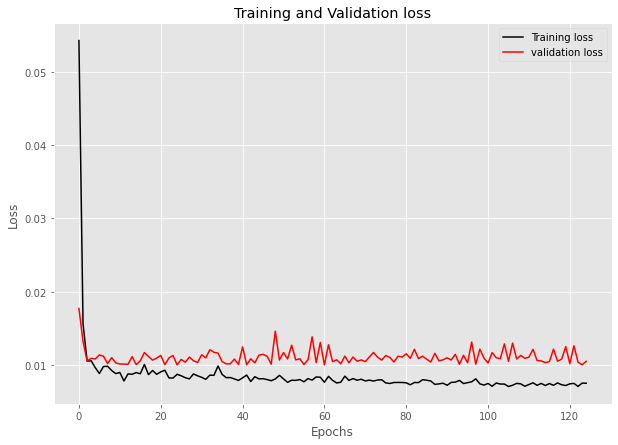

In [157]:
epoch = len(history.history['loss'])
#Plotting the results
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,epoch)
plt.figure(figsize = (10,7))
plt.plot(epochs, loss_train, color="black", label='Training loss')
plt.plot(epochs, loss_val, color="red", label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

We see that the loss curves drop and keep on dropping which means the model improves the more it is trained. 

# Step 6 Evaluate Model Performance

Next the model performance can be assesed after the predictions have been reversed-scaled to get it back to the original scale. 

In [158]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))


# Mean Squared Error (MSE)
MSE = mean_squared_error(y_test_unscaled, y_pred)
print(f'Mean Squared Error (MSE): {np.round(MSE, 2)}')

#Root Mean Squared Error (RMSE)
rmse = np.sqrt(np.mean(((y_pred_scaled - y_test)**2)))
print(f'Root Mean Absolute Error (RMSE): {np.round(rmse, 2)}')

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

# R Squared (R2)
R2 = r2_score(y_test_unscaled, y_pred)
print(f'R Squared (R2): {np.round(R2, 2)}')

Mean Squared Error (MSE): 0.0
Root Mean Absolute Error (RMSE): 0.1
Mean Absolute Error (MAE): 0.01
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 97.09 %
R Squared (R2): 0.01


C:\Users\nixo_\AppData\Local\Temp/ipykernel_6772/2825798527.py:22: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
C:\Users\nixo_\AppData\Local\Temp/ipykernel_6772/2825798527.py:26: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100


Mean absolute error shows how much our prediction on avarage differ from the actual values.

* theese dont give much sense when working with %:
>* MAPE is how much the mean of our predictions deviate from the actual value. 
>* MDAPE is how much the medium of our predictions eviate from the actural value. thereby 50% of the predictions deviate more than 49% from the actual and 50% deviate less than 49% from the acutals

Next we plot the predicted vs. actual values and also the test values:

C:\Users\nixo_\AppData\Local\Temp/ipykernel_6772/211775460.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Date'] = pd.to_datetime(valid['Date'])
C:\Users\nixo_\AppData\Local\Temp/ipykernel_6772/211775460.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Date'] = pd.to_datetime(train['Date'])


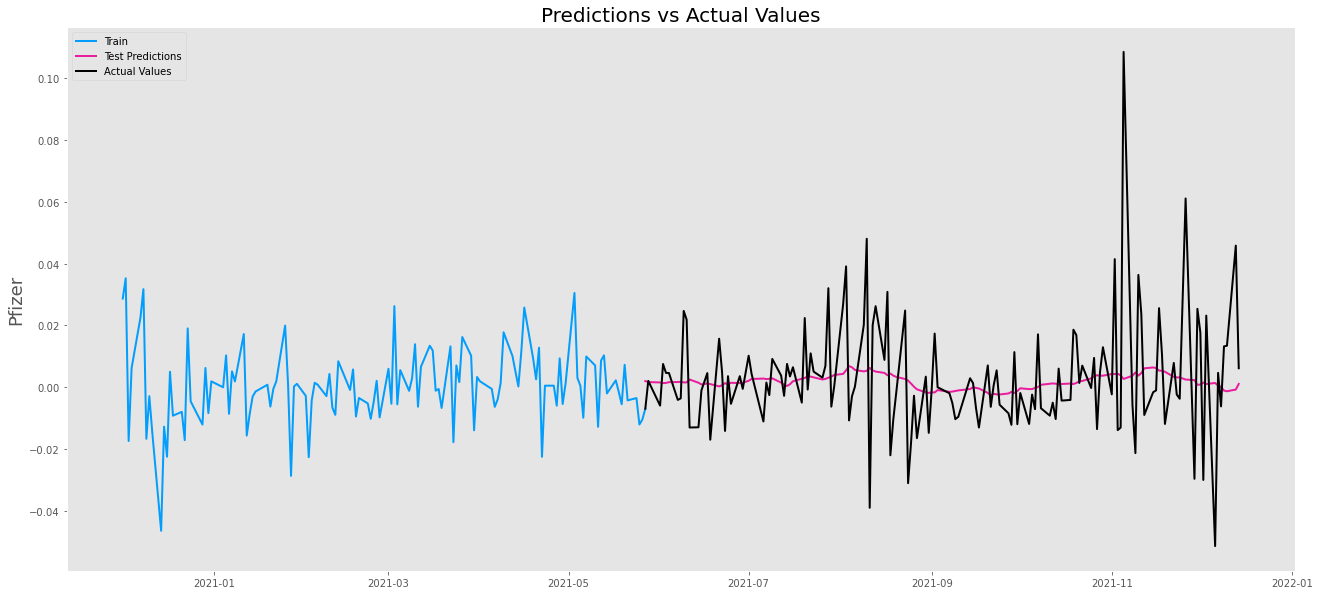

In [159]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=400)

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = date_index

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid[Predict_variable], True)

#Remove timezone
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])


# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[[Predict_variable]]
xv = valid['Date']; yv = valid[[Predict_variable, "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.ylabel(stockname, fontsize=18)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv[Predict_variable], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

#Plotting the results
#plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

We see that the test prediction and the actual values follow eachother quite nice, indicating that the model does a ok job at predicting the stock price. 
In the next section a barplot is made, that shows the difference between predicted and actual stock prices.

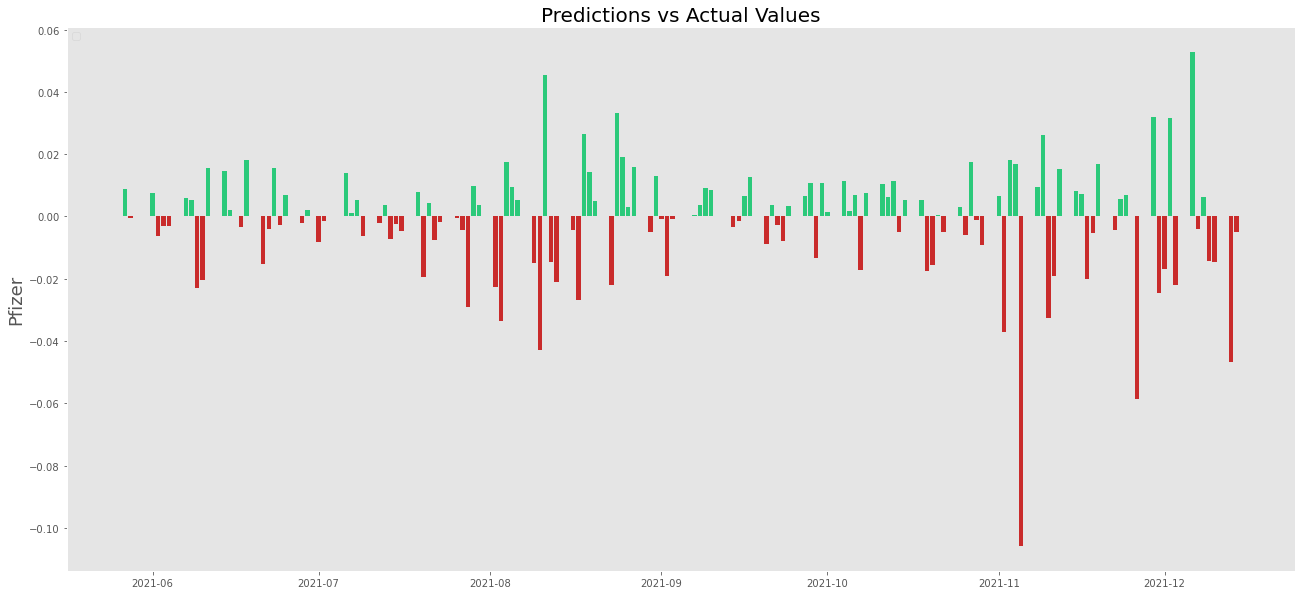

In [160]:
# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
#xt = train['Date']; yt = train[[Predict_variable]]
#xv = valid['Date']; yv = valid[[Predict_variable, "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.ylabel(stockname, fontsize=18)
#plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
#plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
#plt.plot(xv, yv[Predict_variable], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")
# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

#Plotting the results
plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

# Step 7 Predict Next Day’s Price

In [161]:
df_temp = LSTM_df[-sequence_length:]
new_df = df_temp.filter(FEATURES)
stockname = 'Pfizer'
today = dt.datetime.today() - timedelta(days=1)
N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df[Predict_variable][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {today} was {price_today}%')
print(f'The predicted close price is {str(np.round(predicted_price, 3))}%')

The close price for Pfizer at 2022-01-03 08:47:12.122842 was 0.01%
The predicted close price is 0.0%


C:\Users\nixo_\AppData\Local\Temp/ipykernel_6772/2754855120.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)


# Backtesting

In [162]:
len(y_pred)

137

In [163]:
#y_pred_unscaled = scaler_pred.inverse_transform(y_pred)
#x_test_unscaled = data_filtered.tail(len(y_pred_unscaled))
x_test_unscaled = LSTM_df.tail(len(y_pred)).copy()
#x_test_unscaled['Predict_close'] = x_test_unscaled.append(pd.DataFrame(y_pred))
x_test_unscaled['Predict_close'] = y_pred
print(x_test_unscaled.Predict_close.min())
print(x_test_unscaled.Predict_close.max())
x_test_unscaled.to_csv("I:\python_file\save\M4 (1)\LSTM Multi\LSTM_label.csv")

-0.0026765710208564997
0.0068721529096364975


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=520f7743-fdb5-41d4-ba65-deb67c6338e8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>